# Audio Model Training

In [3]:
#Importing the necessary libraries
from functions_audio_model import *
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import zoom
import os
import json
import numpy as np
from torch.utils.data import Dataset

In [16]:
class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, labels):
        self.embedding_dir = embedding_dir
        self.file_list = [f for f in os.listdir(embedding_dir) if f.endswith('.npy')]
        self.labels = labels


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file
        base_name = self.file_list[idx].replace('.npy', '')

        embedding = np.load(os.path.join(self.embedding_dir, base_name + '.npy'))
    
        #label
        label = self.labels[base_name]
        #embedding
        embedding = torch.mean(torch.from_numpy(embedding), dim=1)
        
        return embedding, label

In [86]:
#HYPERPARAMETERS

batchsize = 32
learning_rate = 0.0001
N_EPOCHS = 200

In [87]:
labelsF_test = json.load(open('data/Audio/F_embeddings/labelsF_test.json'))
# print(labelsF_test)
embeddingsF_test_dir = 'data/Audio/F_embeddings/test'
# print(embeddingsF_test_dir)
embeddingsF_test = EmbeddingDataset(embeddingsF_test_dir, labelsF_test)
# print(embeddingsF_test)
test_dataloader= DataLoader(embeddingsF_test, batch_size=batchsize, shuffle=True)

labelsF_train = json.load(open('data/Audio/F_embeddings/labelsF_train.json'))
embeddingsF_train = EmbeddingDataset('data/Audio/F_embeddings/train', labelsF_train)
train_dataloader = DataLoader(embeddingsF_train, batch_size=batchsize, shuffle=True)

labelsF_val = json.load(open('data/Audio/F_embeddings/labelsF_val.json'))
embeddingsF_val = EmbeddingDataset('data/Audio/F_embeddings/val', labelsF_val)
val_dataloader= DataLoader(embeddingsF_val, batch_size=batchsize, shuffle=True)

In [88]:
#Classifier HEAD
class Classifier(nn.Module):
    def __init__(self, num_classes, in_features):
        super(Classifier, self).__init__()
        #Linear Layer
        self.linear = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

train Loss: 0.5038,  ACC: 0.7500, F1-weighted: 0.7434


100%|██████████| 2/2 [00:00<00:00, 99.78it/s]


eval Loss: 0.5305,  ACC: 0.7396, F1-weighted: 0.7369


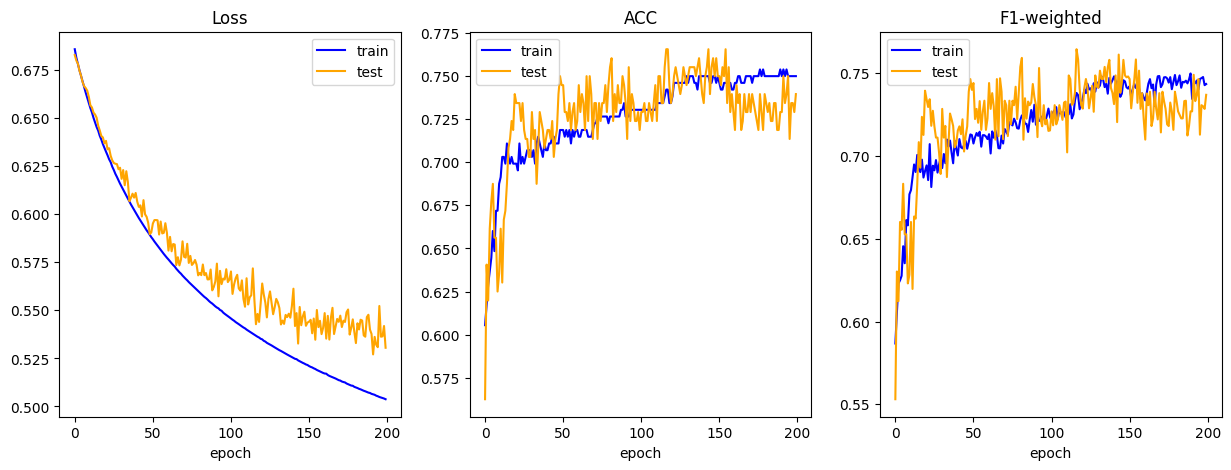

In [89]:
#Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

#Definition of the Model HEAD
#number of features of last layer Wav2Vec2
num_ftrs = 768

#Binary Classification -> Sarcasm or not
num_classes = 2 

model_head = Classifier(num_classes, num_ftrs)

# Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

# Train the model
train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, val_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model_head.state_dict(), results_models_weights_dir + 'audio_model_embeddings.pth')